In [1]:
#%pip install tf_keras_vis tflite-support-nightly

# Create your dataset

1) Choose which classes you would like to add.

2) Create a dataset with your own photos

3) Separate your dataset into train and test subsets.

In [2]:
import os
import pandas as pd
from glob import glob

def create_dataframe_from_directories(path):
    data = []

    for label_dir in os.listdir(path):
        if os.path.isfile(label_dir):
            continue

        label_path_path = os.path.join(path, label_dir)
        for file in os.listdir(label_path_path):
            data.append([os.path.join(label_path_path, file), label_dir])
        
    return pd.DataFrame(data, columns = ["path", "label"])

In [3]:
road_sign_dataset = create_dataframe_from_directories("dataset_train")
#train_df = create_dataframe_from_directories("dataset_train")
#test_df = create_dataframe_from_directories("dataset_test")


In [4]:
LABEL_NAMES = pd.unique(road_sign_dataset['label'])
LABEL_NAMES

array(['Rond', 'Triangle', 'Rectangle'], dtype=object)

**TODO**: Display some images of your dataset

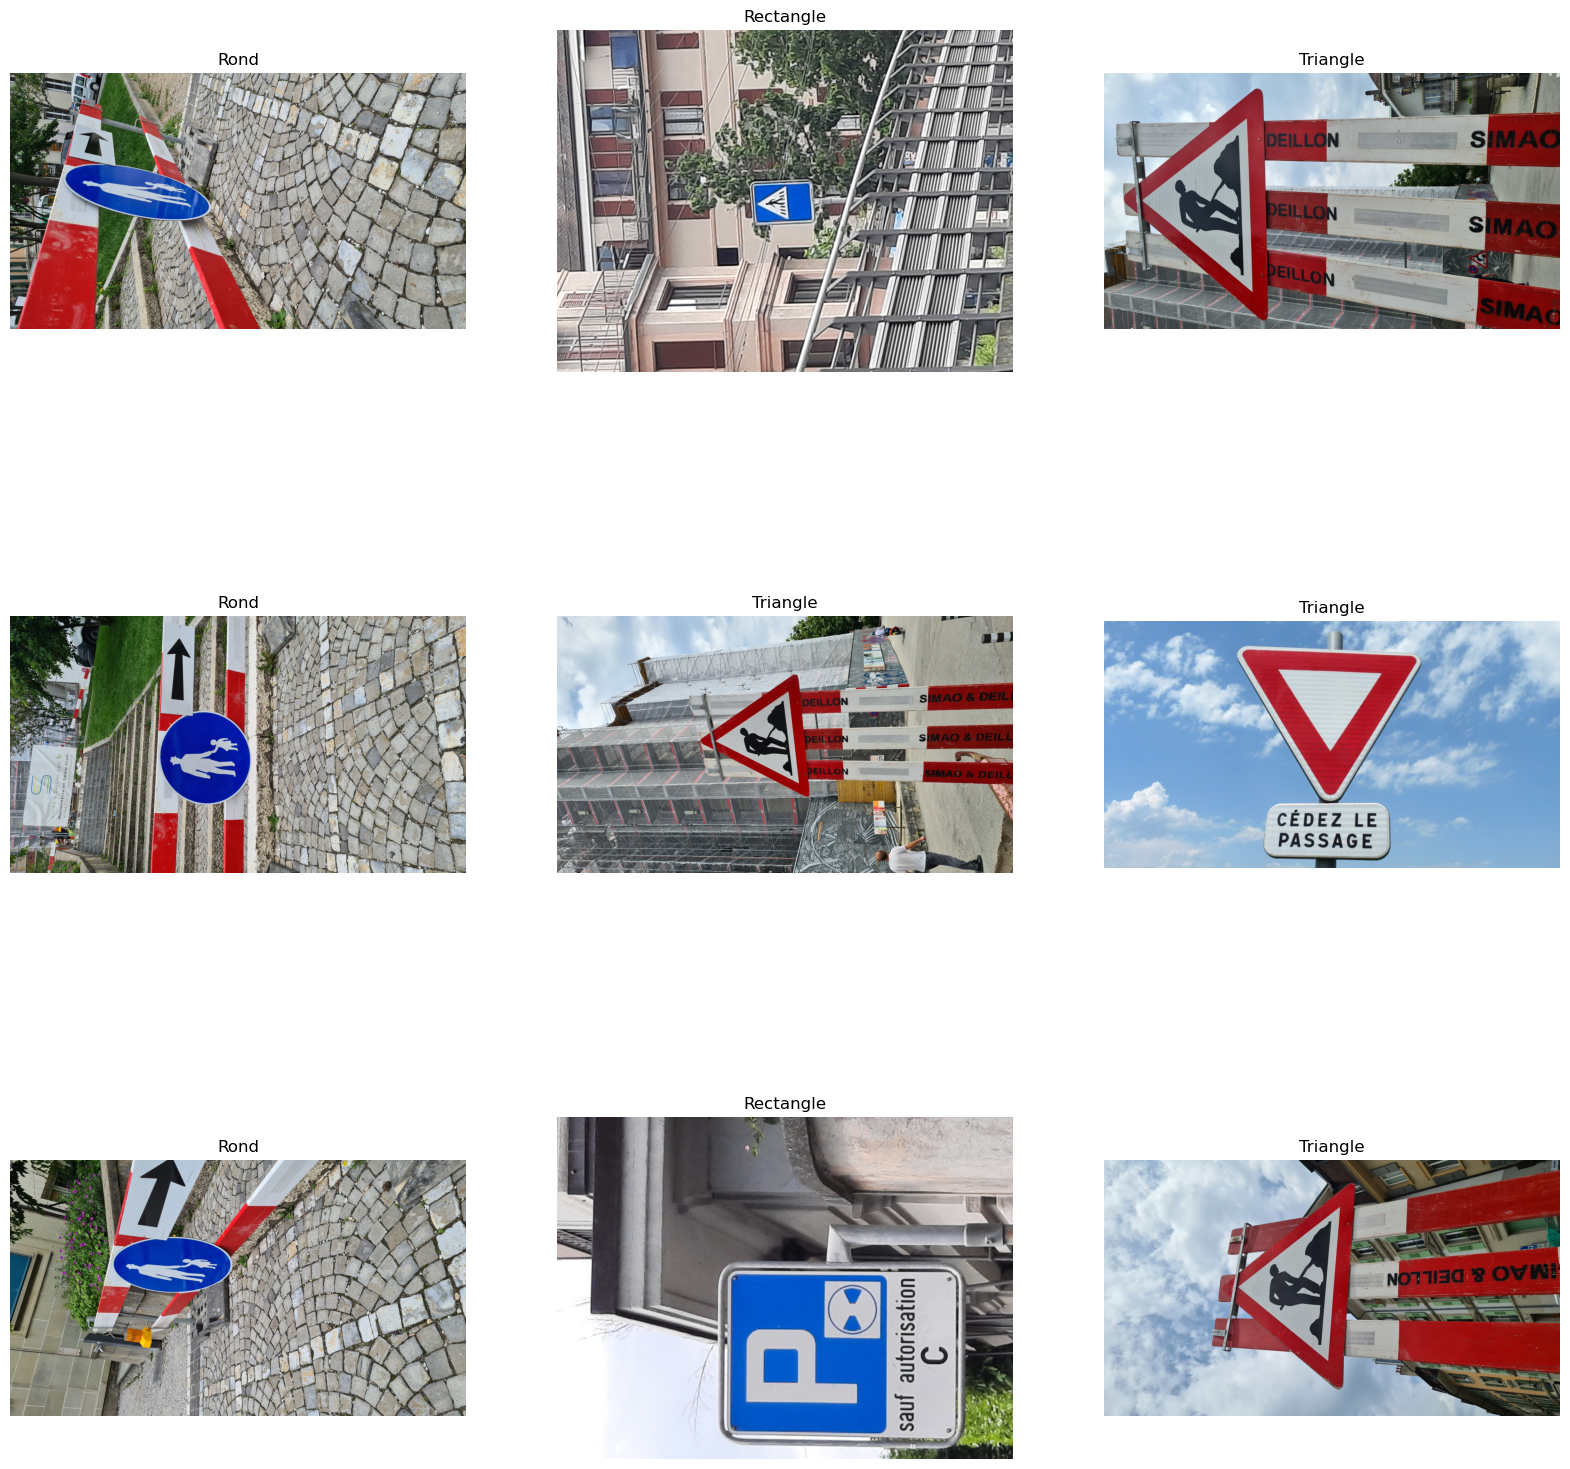

In [5]:
import matplotlib.pyplot as plt
import PIL
import PIL.Image
 
plt.figure(figsize=(20, 20))

i = 0
for _, rowdata in road_sign_dataset.sample(frac=1).head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(PIL.Image.open(rowdata.path))
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1



# Explore your dataset

**TODO**: count the number of examples per classes and plot an histogram of it

<Axes: xlabel='label'>

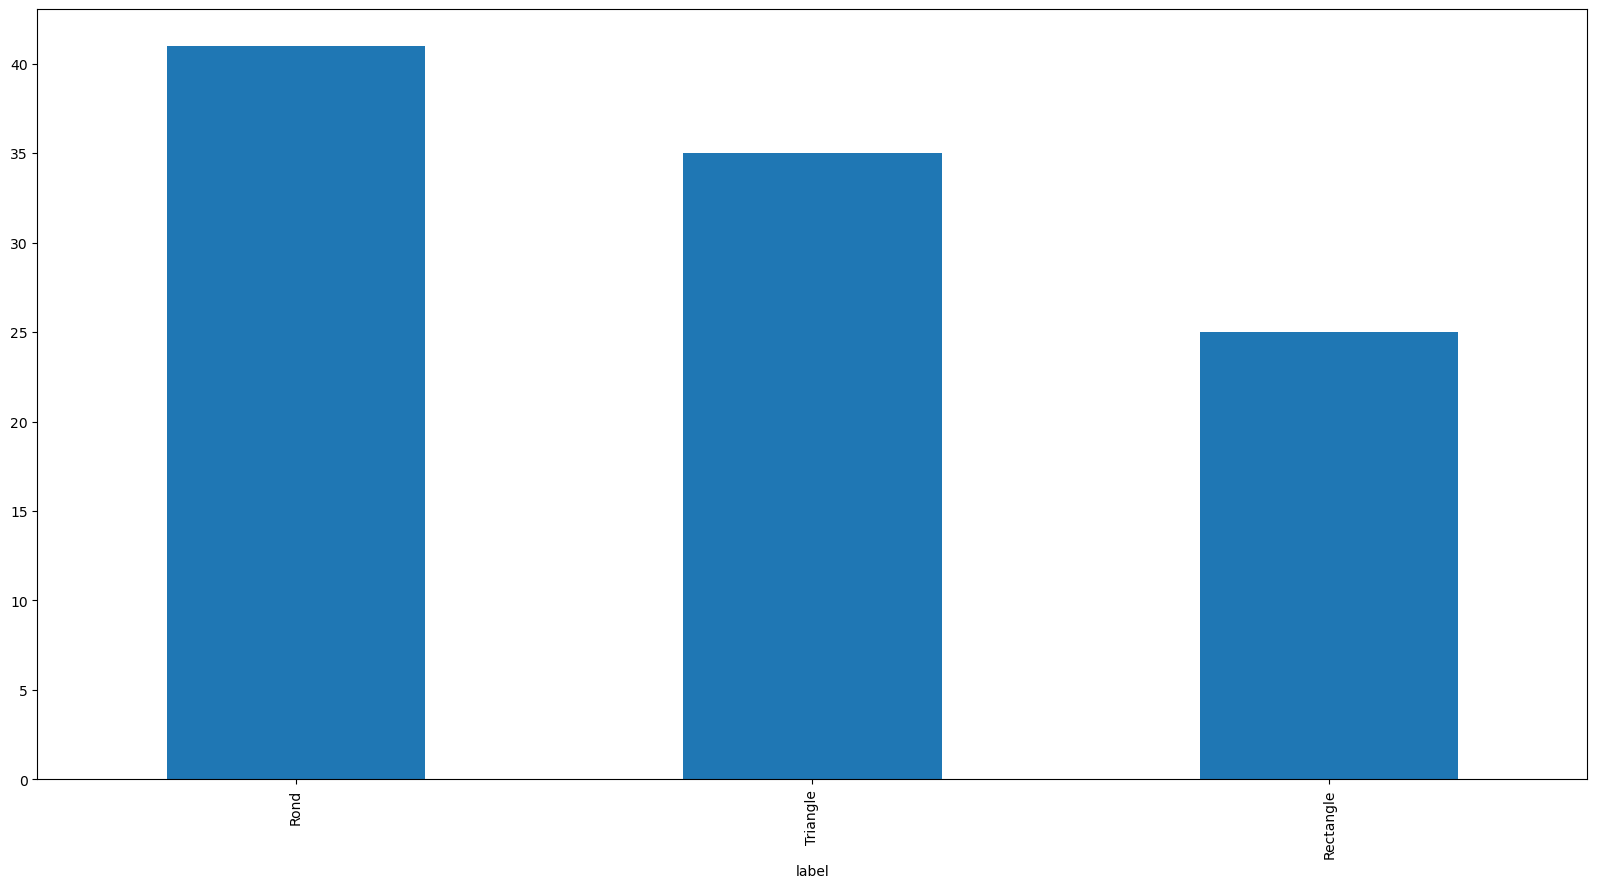

In [6]:

#count the number of examples per classes and plot an histogram of it
plt.figure(figsize=(20, 10))
road_sign_dataset['label'].value_counts().plot(kind='bar')



In [7]:
# print the diff between the max number of images and the 2 others

max_images = road_sign_dataset['label'].value_counts().max()
min_images = road_sign_dataset['label'].value_counts().min()
print("Max images: ", max_images)
print("Min images: ", min_images)

rond = road_sign_dataset['label'].value_counts()['Rond']
Rectangle = road_sign_dataset['label'].value_counts()['Rectangle']
Triangle = road_sign_dataset['label'].value_counts()['Triangle'] 

print("Rond: ", rond)
print("Rectangle: ", Rectangle)
print("Triangle: ", Triangle)


Max images:  41
Min images:  25
Rond:  41
Rectangle:  25
Triangle:  35


# Preprocessing steps

In [8]:
from tensorflow.keras.layers import (
    Resizing, Rescaling,
)

from tensorflow.keras import Sequential
import tensorflow.keras.layers as layers
import numpy as np

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

image_augmentations = Sequential([
    # TODO: choose some image augmentations layers
    # see which keras layers you can use
    # The kind of layers you will want to use starts with "Random".
    # See the following page for more information on data augmentation :
    # https://www.tensorflow.org/tutorials/images/data_augmentation

    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(factor=(-0.2, 0.2)),
    layers.RandomContrast(0.5),
])

def open_images(paths):
    return np.stack([
        open_image(path) for path in paths
    ])

def open_image(path):
    with PIL.Image.open(path) as image:
        opened_img = image_preprocesses(np.asarray(image))
    
    return opened_img

def augment_images(images):
    return np.stack([
        image_augmentations(img) for img in images
    ])

def add_n_augmented_images(images, labels, n):
    augmented_images = np.concatenate([augment_images(images) for _ in range(n)])
    return np.concatenate([images, augmented_images]), np.concatenate([labels for _ in range(n+1)])

2024-06-08 12:36:27.538426: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 12:36:27.858238: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 12:36:29.090135: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 12:36:34.049476: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**TODO**: plot examples of preprocessed and augmented images

In [ ]:

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def display_augmented_images(image_paths, num_samples=9):
    plt.figure(figsize=(20, 20))
    for i, path in enumerate(image_paths[:num_samples]):
        img = open_image(path)
        augmented_img = image_augmentations(img)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_img)
        plt.title("Augmented Image")
        plt.axis("off")
    plt.show()


dataset_path = road_sign_dataset['path']
dataset_labels = road_sign_dataset['label']

train_path, test_path, train_label, test_label = train_test_split(dataset_path,dataset_labels, test_size=0.2, random_state=42)

# Prétraitement et augmentation des données
train_images_raw = np.stack([open_image(path) for path in train_path])
#train_labels = train_label.to_numpy()

test_images_raw = np.stack([open_image(path) for path in test_path])
#test_labels = test_label.to_numpy()

# Augmentation des images d'entraînement
NUMBER_OF_AUGMENTATIONS = 2
train_images_augmented, train_labels_augmented = add_n_augmented_images(train_images_raw, train_label, NUMBER_OF_AUGMENTATIONS)

# Affichage des images augmentées
display_augmented_images(train_path)



## Define model

In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout
)

def get_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )
    
    layers = base_model.output

    added_layers = [
        # important, we need global average pooling instead of flatten for class activation map later on 
        GlobalAveragePooling2D(), 
        # TODO: ...
    ]

    model = Model(inputs=base_model.input, outputs=Sequential(added_layers)(layers))

    # TODO: freeze layers
    
    model.compile(
      optimizer = RMSprop(),
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )
        
    return model

In [ ]:
get_model().summary()

In [12]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Flatten,
    Dense,
    Dropout
)

def get_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )
    
    layers = base_model.output

    # TODO: Here we need to make the changes. So we havec
    added_layers = [
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        # 3 is the number of classes
        Dense(3, activation='softmax')
    ]

    model = Model(inputs=base_model.input, outputs=Sequential(added_layers)(layers))

    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(
      optimizer = RMSprop(),
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )
    
    return model

 

In [ ]:
get_model().summary()

# Model training

**TODO**: cross-validate your model, you can base yourself on the code from the first part of this practical work

**NOTE**: you shouldn't augment validations images. What we want to evaluate is the performances on "real" images, not on images that are augmented and change all the time 

In [14]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

label_encoder = LabelEncoder()
label_encoder.fit(LABEL_NAMES)
total_train_labels = label_encoder.transform(train_labels_augmented)
test_labels = label_encoder.transform(test_label)

NB_EPOCHS = 4

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for train_index, val_index in KFold(n_splits=5).split(train_images_augmented, total_train_labels):
    image_train, image_val = train_images_augmented[train_index], train_images_augmented[val_index]
    label_train, label_val = total_train_labels[train_index], total_train_labels[val_index]
    
    
    model = get_model() 

    history = model.fit(
        x=image_train,
        y=label_train,
        batch_size=32,
        validation_data=(image_val, label_val),
        epochs=NB_EPOCHS
    )

    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])

Epoch 1/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 47s 6s/step - acc: 0.3244 - loss: 133.6847 - val_acc: 0.6458 - val_loss: 39.2790
Epoch 2/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - acc: 0.6743 - loss: 26.7040 - val_acc: 0.8333 - val_loss: 1.9847
Epoch 3/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - acc: 0.9594 - loss: 1.6727 - val_acc: 0.8750 - val_loss: 2.4679
Epoch 4/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - acc: 0.9532 - loss: 1.4156 - val_acc: 0.9375 - val_loss: 1.2269
Epoch 1/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - acc: 0.4007 - loss: 144.3495 - val_acc: 0.3333 - val_loss: 128.9067
Epoch 2/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - acc: 0.7199 - loss: 37.4198 - val_acc: 0.8333 - val_loss: 5.1736
Epoch 3/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - acc: 0.9385 - loss: 0.9221 - val_acc: 0.8542 - val_loss: 4.4086
Epoch 4/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - acc: 0.9656 - loss: 0.7855 - val_acc: 0.8750 - val_loss: 1.2628
Epoch 1/4
6/6 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - acc: 0.3585 - loss: 148.3385 - val_acc

**TODO**: plot the results from your crossvalidation

# Results

In [ ]:
import matplotlib.pyplot as pl


def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)
    
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='orange', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='orange', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    #pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    ax.legend()
    ax.grid()

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,6))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss")
plot_kfold_mean_performance(axs[1], train_accuracies, val_accuracies, "Accuracy")


## Evaluate model on test set

**TODO**: when you've selected a final model, evaluate its performances (f-score, confusion matrix, ...) on your test set

In [1]:
import sklearn.metrics as me

train_images = train_images_augmented
train_labels = total_train_labels

model = get_model() # We reinitialize the model

history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=32,
    epochs=NB_EPOCHS,
)

pred = model.predict(test_images_raw)
pred = np.argmax(pred, axis=-1)

test_confusion_matrix = me.confusion_matrix(test_labels, pred, labels=np.arange(len(LABEL_NAMES)))


confusion_matrix_display = me.ConfusionMatrixDisplay(
    confusion_matrix=test_confusion_matrix,
    display_labels=LABEL_NAMES,
)

confusion_matrix_display.plot(xticks_rotation='vertical')
plt.show()



f1 = me.f1_score(test_labels, pred, average='macro')
print("F1 score: ", f1)

accuracy = me.accuracy_score(test_labels, pred)
print("Accuracy: ", accuracy)


NameError: name 'train_images_augmented' is not defined

### Display some misclassified images

**TODO**: display some misclassified images to be able to see what images are difficult for the model

## Use grad-cam to inspect how the model classify
Here we can see an heatmap of the regions that activates the model the most.

### For more information:
- tf-keras-vis documentation: https://keisen.github.io/tf-keras-vis-docs/
- Grad-cam paper: https://arxiv.org/pdf/1610.02391.pdf
- Grad-cam++ paper: https://arxiv.org/pdf/1710.11063.pdf

**NOTE**: maybe you will need to adapt some variable names based on your code above. For example, _model_ should be the model trained on all the training data. 

In [15]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.applications import MobileNetV2
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Create GradCAM++ object
gradcam = GradcamPlusPlus(
    model,
    model_modifier=ReplaceToLinear(),
    clone=True,
)

nb_images_per_class = 10

fig, axs = plt.subplots(nb_images_per_class, len(LABEL_NAMES), figsize=(len(LABEL_NAMES) * 5, nb_images_per_class * 5))

for label_idx, label_name in enumerate(LABEL_NAMES):
    axs[0,label_idx].set_title(label_name, loc='center', y=1.1)
    
    i = 0
    for _, rowdata in train_df[train_df['label'] == label_name].sample(frac=1).head(nb_images_per_class).iterrows():
        img = open_image(rowdata.path)    
        pred = model(np.expand_dims(img, axis=0))

        # Generate cam with GradCAM++
        score = CategoricalScore(np.argmax(pred))
        cam = gradcam(score, img)
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

        axs[i,label_idx].imshow(img, vmin=0, vmax=1)
        axs[i,label_idx].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        axs[i,label_idx].axis("off")

        i += 1

NameError: name 'train_df' is not defined

Error in callback <function flush_figures at 0x7ef2e8adaac0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

### Grad-cam on misclassified images

**TODO**: now do the same than above, but with the misclassified images. You shouldn't change anything pertaining to grad-cam besides on which image and prediction you do it

**TODO**: try to determine what caused the misclassifcations and what you can do about it